## Econometric estimation of an IRL-based market portfolio model

Welcome to your final course project on RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns that is based on IRL of a market-optimal portfolio 
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
- Compare simple IRL-based and UL-based trading strategies

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Complete the model estimation for the DJI portfolio of 30 stocks, and simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Propose other signals and investigate the dynamics for market caps obtained with alternative signals. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Can you repeat your analysis for the S&P portfolio? You will have to build a data file, build signals, and repeat the model estimation process with your new dataset (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis. For example, you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your first IRL based model of market dynamics, and learn how this IRL approach extends the famous Black-Litterman model (see F. Black and R. Litterman, "Global Portfolio Optimization", Financial Analyst Journal, Sept-Oct. 1992, 28-43, and  D. Bertsimas, V. Gupta, and I.Ch. Paschalidis, "Inverse Optimization: A New Perspective on the Black-Litterman Model", Operations Research, Vol.60, No.6, pp. 1389-1403 (2012), I.Halperin and I. Feldshteyn "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498.). 
- Know how to enhance a market-optimal portfolio policy by using your private signals. 
- Be able to implement trading strategies based on this method.

Let's get started!

## The IRL-based model of stock returns

In Week 4 lectures of our course we found that optimal investment policy in the problem of inverse portfolio optimization is a Gaussian policy

$$ \pi_{\theta}({\bf a}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf a}_t | \bf{A}_0 + \bf{A}_1 {\bf y}_t, \Sigma_p \right) $$

Here $ {\bf y}_t $ is a vector of dollar position in the portfolio, and $ \bf{A}_0 $, $ \bf{A}_1 $ and $ \Sigma_p $ are parameters defining a Gaussian policy.   

We said in the lecture that such Gaussian policy is found for both cases of a single investor and a market portfolio. We also sketched a numerical scheme that can iteratively compute coefficients $ \bf{A}_0$, $ \bf{A}_1 $ and $ \Sigma_p $ using a combination of a RL algorithm called G-learning and a trajectory optimization algorithm.

In this project, you will explore implications and estimation of this IRL-based model for the most interesting case - the market portfolio. It turns out that for this case, the model can be estimated in an easier way using a conventional Maximum Likelihood approach. To this end, we will re-formulate the model for this particular case in three easy steps.


Recall that for a vector of $ N $ stocks, we introduced a size $ 2 N $-action vector 
$ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)}] $, so that an action $ {\bf u}_t $ was defined as a difference of two non-negative numbers 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} = [{\bf 1}, - {\bf 1}] {\bf a}_t \equiv {\bf 1}_{-1}^{T} {\bf a}_t $.

Therefore, the joint distribution of $ {\bf a}_t = [{\bf u}_t^{(+)}, {\bf u}_t^{(-)} ] $ is given by our Gaussian policy
$  \pi_{\theta}({\bf a}_t |{\bf y}_t ) $. This means that the distribution of 
$ {\bf u}_t = {\bf u}_t^{(+)} -  {\bf u}_t^{(-)} $ is also Gaussian. Let us write it therefore as follows:

$$
\pi_{\theta}({\bf u}_t |{\bf y}_t ) =   \mathcal{N}\left({\bf u}_t | \bf{U}_0 + \bf{U}_1 {\bf y}_t, \Sigma_u \right) 
$$

Here $ \bf{U}_0 = {\bf 1}_{-1}^{T}  \bf{A}_0 $ and $ \bf{U}_1 =  {\bf 1}_{-1}^{T}  \bf{A}_1 $.

This means that $ {\bf u}_t $ is a Gaussian random variable that we can write as follows:

$$
{\bf u}_t = \bf{U}_0 + \bf{U}_1 {\bf y}_t + \varepsilon_t^{(u)}  = \bf{U}_0 + \bf{U}_1^{(x)} {\bf x}_t + \bf{U}_1^{(z)} {\bf z}_t + \varepsilon_t^{(u)} 
$$

where $ \varepsilon_t^{(u)} \sim \mathcal{N}(0,\Sigma_u) $ is a Gaussian random noise.  

The most important feature of this expression that we need going forward is is linear dependence on the state $ {\bf x}_t $. 
This is the only result that we will use in order to construct a simple dynamic market model resulting from our IRL model. We use a deterministic limit of this equation, where in addition we set $ \bf{U}_0 = \bf{U}_1^{(z)} = 0 $, and replace $ \bf{U}_1^{(x)} \rightarrow \phi $ to simplify the notation. We thus obtain a simple deterministic policy

$$
\label{determ_u}
{\bf u}_t =  \phi  {\bf x}_t 
$$

Next, let us recall the state equation and return equation (where we reinstate a time step $ \Delta t $,
and $ \circ $ stands for an element-wise (Hadamard) product):

$$
X_{t+ \Delta t} = (1 + r_t \Delta t) \circ (  X_t +  u_t  \Delta t)  
$$
$$
r_t   = r_f + {\bf w} {\bf z}_t -  \mu  u_t + \frac{\sigma}{ \sqrt{ \Delta t}} \varepsilon_t 
$$
where $ r_f $ is a risk-free rate, $ \Delta t $ is a time step, $ {\bf z}_t $ is a vector of predictors with weights $ {\bf w} $, $ \mu $ is a market impact parameter with a linear impact specification, and $ \varepsilon_t \sim \mathcal{N} (\cdot| 0, 1) $ is a white noise residual.


Eliminating $ u_t $ from these expressions and simplifying, we obtain
$$ \Delta  X_t = \mu  \phi  ( 1 + \phi \Delta t) \circ  X_t \circ \left(  \frac{r_f (1 + \phi \Delta t)  + \phi}{ \mu \phi (1+ \phi \Delta t )}  -  X_t \right) \Delta t + 
( 1 + \phi \Delta t) X_t  \circ \left[ {\bf w} {\bf z}_t  \Delta t +  \sigma \sqrt{ \Delta t} \varepsilon_t \right]
$$
Finally, assuming that $ \phi \Delta t \ll 1 $ and taking the continuous-time limit $  \Delta t \rightarrow dt $, we obtain 

$$
d X_t = \kappa \circ X_t \circ \left( \frac{\theta}{\kappa} - X_t \right) dt +  X_t \circ \left[ {\bf w} {\bf z}_t \, dt + \sigma d W_t \right]
$$
where $\kappa   =   \mu  \phi $, $ \theta  =   r_f + \phi $, and $ W_t $ is a standard Brownian motion.

Please note that this equation describes dynamics with a quadratic mean reversion. It is quite different from models with linear mean reversion such as the Ornstein-Uhlenbeck (OU) process. 

Without signals $ {\bf z}_t $, this process is known in the literature as a Geometric Mean Reversion (GMR) process. It has been used (for a one-dimensional setting) by Dixit and Pyndick (" Investment Under Uncertainty", Princeton 1994), and investigated (also for 1D) by Ewald and Yang ("Geometric Mean Reversion: Formulas for the Equilibrium Density and Analytic Moment Matching", {\it University of 
St. Andrews Economics Preprints}, 2007). We have found that such dynamics (in a multi-variate setting) can also be obtained for market caps (or equivalently for stock prices, so long as the number of shares is held fixed) using Inverse Reinforcement Learning! 

(For more details, see I. Halperin and I. Feldshteyn, "Market Self-Learning of Signals, Impact and Optimal Trading: Invisible Hand Inference with Free Energy.
(or, How We Learned to Stop Worrying and Love Bounded Rationality)", https://papers.ssrn.com/sol3/papers.cfm?abstract\_id=3174498) 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937537e+11,48660795480,4.082033e+10,36460724400,1.420313e+11,1.586155e+11,6.168697e+10,3.337392e+10,1.645038e+11,8.897731e+10,...,25598248500,1.527563e+11,178576382080,27214839130,36638396010,67155918570,41337043020,94536765440,206625627560,3.272107e+11
2010-01-05,1.940887e+11,48553770270,4.215727e+10,36896634000,1.413985e+11,1.597391e+11,6.153308e+10,3.486077e+10,1.653556e+11,9.055040e+10,...,25700093100,1.505775e+11,178634816760,26570118990,36580295160,66152751840,40863360090,94707204320,204568134680,3.284884e+11
2010-01-06,1.910015e+11,49338621810,4.343609e+10,37008725040,1.404781e+11,1.597591e+11,6.120609e+10,3.547838e+10,1.645038e+11,8.958393e+10,...,25543409100,1.500934e+11,177787513900,26193121620,36940520430,65805862410,40314638280,90673484160,204110914040,3.313275e+11
2010-01-07,1.906484e+11,49921314620,4.519446e+10,37158179760,1.411109e+11,1.591572e+11,6.122532e+10,3.550126e+10,1.730218e+11,9.133695e+10,...,26172872700,1.495285e+11,176823341680,26570118990,38358181170,66087124110,40689832680,90133761040,204225219200,3.302865e+11
2010-01-08,1.919159e+11,49885639550,4.475850e+10,37575407520,1.418587e+11,1.594381e+11,6.132150e+10,3.562706e+10,1.767484e+11,8.960963e+10,...,26121202640,1.507389e+11,176589602960,26531872880,37997955900,66218379570,40802391000,90190574000,203196472760,3.289615e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

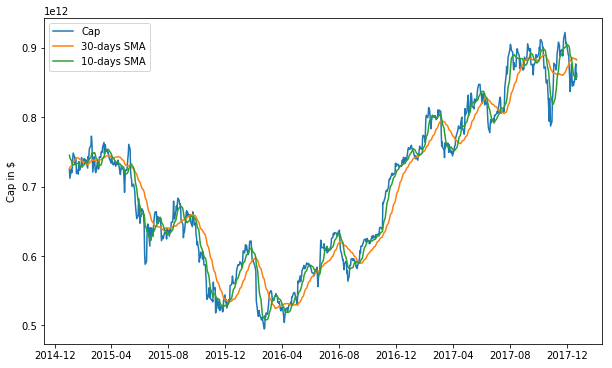

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with moving average signals (Max 10 points)

Recall the equation for the dynamics of market portfolio: 

$$ \Delta {\bf x}_t = \kappa_x \circ  {\bf x}_t \circ 
\left( {\bf W}{\bf z}_t'  - {\bf x}_t \right)  +  {\bf x}_t  \circ \varepsilon_t^{(x)} $$

Here we change the notation a bit. Now $ {\bf z}_t' $ is an extended vector of predictors that includes a constant unit predictor $  {\bf z}_t' = [1, {\bf z}_t ]^T $. Therefore, for each name, if you have $ K = 2 $ signals, an extended vector of signals $ {\bf z}_t' $ is of length $ K + 1 $, and the  $ W $ stands for a factor loading matrix.
The negative log-likelihood function for observable data with this model is therefore

$$  LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ (2 \pi)^{N}  \left| \Sigma_x \right| }} 
e^{ - \frac{1}{2} \left(   {\bf v}_t
 \right)^{T} 
\Sigma_x^{-1}  
\left(  {\bf v}_t \right)} $$

where

$$  {\bf v}_t \equiv \frac{{\bf x}_{t+1} -  {\bf x}_{t}}{{\bf x}_{t}}  
-  \kappa_x \circ \left({\bf W} {\bf z}_t'   - {\bf x}_t \right)  $$

and $ \Sigma_x $ is the covariance matrix that was specified above in terms of other parameters. Here we directly infer the value of $ \Sigma_x $, along with other parameters, from data, so we will not use these previous expressions. 

Parameters that you have to estimate from data are therefore the vector of mean reversion speed 
parameters $ \kappa_x $, factor loading matrix $ {\bf W} \equiv {\bf w}_z' $, and covariance matrix $ \Sigma_x $. 

Now, you are free to impose some structure on this parameters. Here are some choice, in the order of increasing complexity:

- assume that all values in vector-valued and matrix-valued parameters are the same, so that they can parametrized by scalars, e.g. $ \kappa_x = \kappa {\bf 1}_N $ where $ \kappa $ is a scalar value, and $ {\bf 1}_N $ is a vector of ones of length $ N $ where $ N $ is the number of stocks in the market portfolio. You can proceed similarly with specification of factor loading matrix $ W' $. Assume that all values in (diagonal!) factor loading matrices are the same for all names, and assume that all correlations and variances in the covariance matrix $ \Sigma_x $ are the same for all names.   

- Assume that all values are the same only within a given industrial sector.


- You can also change the units. For example, you can consider logs of market caps instead of market caps themselves, ie. change the variable from $ {\bf x}_t  $ to $ {\bf q}_t = \log {\bf x}_t $


In [7]:
# Put the rest of you code and analysis for Part I here 

# Calculate Market means & Simple Moving Averages
Market_means = df_cap.sum(axis=1).mean()
SMA_10d = short_rolling / Market_means
SMA_30d = long_rolling / Market_means
SMA_df_cap = df_cap / Market_means

# Validated, De-meaned & Cleaned
SMA_10d_vdc = (SMA_10d/SMA_10d.loc[SMA_10d.first_valid_index()]).pct_change(periods=1).shift(-1).dropna()
SMA_30d_vdc = (SMA_30d/SMA_30d.loc[SMA_30d.first_valid_index()]).pct_change(periods=1).shift(-1).dropna()

# Reduce Market dates to dates without Nans
Cap_Market = SMA_df_cap[29:-1]
Cap_Market = Cap_Market[Cap_Market.index.isin(SMA_10d_vdc.index) & Cap_Market.index.isin(SMA_10d_vdc.index)]
SMA_10d_vdc = SMA_10d_vdc[SMA_10d_vdc.index.isin(Cap_Market.index)]
SMA_30d_vdc = SMA_30d_vdc[SMA_30d_vdc.index.isin(Cap_Market.index)]

In [8]:
# Time stamps & number of stocks
ts = Cap_Market.shape[0]
ns = Cap_Market.shape[1]

# number of signals
k = 2

# Dataframe to hold results
results = pd.DataFrame([],index = Cap_Market.columns,columns=['kappa','sigma','sigma^2','w1','w2'])

# Calibration with TF
tf.reset_default_graph()
x = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='x')
s1 = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='s1') 
s2 = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='s2')

# Variables
N_k = ns
N_s = ns
N_w = ns
kappa = tf.get_variable("kappa",initializer=tf.random_uniform([N_k],minval= 0.0,maxval=1.0))
sigma = tf.get_variable("sigma",initializer=tf.random_uniform([N_s],minval=0.0,maxval=0.1))

# Weights
w1_init = tf.random_normal([N_w],mean=0.5,stddev=0.1 )
w2_init = 1-w1_init
w1 = tf.get_variable("w1",initializer=w1_init)
w2 = tf.get_variable("w2",initializer=w2_init )
W1 = w1*tf.ones(ns)
W2 = w2*tf.ones(ns)

# Parameters
mu = tf.zeros([ns])
Sigma = sigma*tf.ones([ns])
theta1 = tf.multiply(W1,s1)
theta2 = tf.multiply(W2,s2)
scale = tf.slice(x,[0,0],[1,-1] )
theta = tf.multiply(scale,tf.cumprod(1+tf.add(theta1,theta2)))
r = tf.divide(tf.subtract(tf.manip.roll(x,shift=-1,axis = 0),x),x)
v = tf.subtract(r,tf.multiply(kappa,tf.subtract(theta,x)))
vuse = tf.slice(v,[0,0],[tf.shape(v)[0]-1,-1] )

#  Constraints 
clip_w1 = w1.assign(tf.maximum(0.,w1))
clip_w2 = w2.assign(tf.maximum(0.,w2))
clip = tf.group(clip_w1,clip_w2)
dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob)+0.01*reg_term

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(neg_log_likelihood)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [9]:
# Maximum Iterations & Tolerance
max_iter = 2500
tol = 1e-10

# Savew the Model
saver = tf.train.Saver()

# Run TF Session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = sess.run([neg_log_likelihood], feed_dict={x:Cap_Market,s1:SMA_10d_vdc,s2:SMA_30d_vdc})
    i=1

    # Print Calibration
    print( "Calibration" )
    print("Iteration|      Loss      |   difference")
    while True:
        sess.run(train_op,feed_dict={x:Cap_Market,s1:SMA_10d_vdc,s2:SMA_30d_vdc})
        sess.run(clip)
        # update loss
        new_loss = sess.run(neg_log_likelihood,feed_dict={x:Cap_Market,s1:SMA_10d_vdc,s2:SMA_30d_vdc})
        loss_diff = np.abs(new_loss-losses[-1])
        losses.append(new_loss)
        if i%min(1000,(max_iter/20))==1:
            print ("{:8} | {:14.4f} | {:12.4f}".format(i,new_loss,loss_diff))
        if loss_diff < tol:
            print('Loss converge in {} iterations!'.format(i))
            break
        if i >= max_iter:
            print('Maximum number of iterations reached (no convergence).')
            break
        i += 1

    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)
    fitted_means = sess.run(theta, feed_dict={x:Cap_Market,s1:SMA_10d_vdc,s2:SMA_30d_vdc})
    mean_levels = pd.DataFrame(fitted_means,index=Cap_Market.index,columns=Cap_Market.columns)
    
    # Print Results
    print( "Results" )
    print(results.round(4))
    
    save_path = saver.save(sess, './part1.ckpt')
    print( 'Checkpoint saved in: {}'.format(save_path))

Calibration
Iteration|      Loss      |   difference
       1 |   7885347.5000 | 89965104.0000
     126 |    184273.0625 |     334.5625
     251 |    141329.3906 |     344.9062
     376 |    100142.6719 |     311.1016
     501 |     64949.3438 |     242.4883
     626 |     38995.6641 |     186.4922
     751 |     18743.3516 |     147.1250
     876 |      1709.3951 |     126.2271
    1001 |    -12949.8643 |     109.0742
    1126 |    -25659.4941 |      94.9102
    1251 |    -36765.7422 |      83.2852
    1376 |    -46545.5898 |      73.5742
    1501 |    -55220.2383 |      65.4844
    1626 |    -62966.8711 |      58.6953
    1751 |    -69927.8047 |      52.8828
    1876 |    -76218.6016 |      47.8984
    2001 |    -81933.4531 |      43.6406
    2126 |    -87149.7734 |      39.9375
    2251 |    -91931.9219 |      36.6719
    2376 |    -96333.5234 |      33.8438
Maximum number of iterations reached (no convergence).
Results
       kappa   sigma  sigma^2      w1      w2
AAPL  0.3786  0.0

Part 1 Conclusion, the calibration of the model converges most of the time in less than a 2,500 iterations, this is a relative low maximum set to avoid extra computer time.

## Part 2: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


The proposed signals is to use an exponential moving average (EMA) intead of the simple moving average used above. The EMA advantage is that it places a greater weight and significance on the most recent data points.

In [10]:
# Put the rest of your code and analysis for Part 2 here.

# Calculate EMAs and their means
Exp_short_rolling = df_cap.ewm(span=window_1,adjust=False).mean()
Exp_long_rolling = df_cap.ewm(span=window_2,adjust=False).mean()

# Calculate Market means & Simple Moving Averages
Market_means = df_cap.sum(axis=1).mean()
EMA_10d = Exp_short_rolling / Market_means
EMA_30d = Exp_long_rolling / Market_means
EMA_df_cap = df_cap / Market_means

# Validated, De-meaned & Cleaned
EMA_10d_vdc = (EMA_10d/EMA_10d.loc[EMA_10d.first_valid_index()]).pct_change(periods=1).shift(-1).dropna()
EMA_30d_vdc = (EMA_30d/EMA_30d.loc[EMA_30d.first_valid_index()]).pct_change(periods=1).shift(-1).dropna()

# Reduce Market dates to dates without Nans
Cap_Market = EMA_df_cap[29:-1]
Cap_Market = Cap_Market[Cap_Market.index.isin(EMA_10d_vdc.index) & Cap_Market.index.isin(EMA_10d_vdc.index)]
EMA_10d_vdc = EMA_10d_vdc[EMA_10d_vdc.index.isin(Cap_Market.index)]
EMA_30d_vdc = EMA_30d_vdc[EMA_30d_vdc.index.isin(Cap_Market.index)]

In [11]:
# Time stamps & number of stocks
ts = Cap_Market.shape[0]
ns = Cap_Market.shape[1]

# number of signals
k = 2

# Dataframe to hold results
results = pd.DataFrame([],index = Cap_Market.columns,columns=['kappa','sigma','sigma^2','w1','w2'])

# Calibration with TF
tf.reset_default_graph()
x = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='x')
s1 = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='s1') 
s2 = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='s2')

# Variables
N_k = ns
N_s = ns
N_w = ns
kappa = tf.get_variable("kappa",initializer=tf.random_uniform([N_k],minval=0.0,maxval=1.0))
sigma = tf.get_variable("sigma",initializer=tf.random_uniform([N_s],minval=0.0,maxval=0.1))

# Weights
w1_init = tf.random_normal([N_w],mean=0.5,stddev=0.1 )
w2_init = 1-w1_init
w1 = tf.get_variable("w1",initializer=w1_init)
w2 = tf.get_variable("w2",initializer=w2_init )
W1 = w1*tf.ones(ns)
W2 = w2*tf.ones(ns)

# Parameters
mu = tf.zeros([ns])
Sigma = sigma*tf.ones([ns])
theta1 = tf.multiply(W1,s1)
theta2 = tf.multiply(W2,s2)
scale = tf.slice(x,[0,0],[1,-1] )
theta = tf.multiply(scale,tf.cumprod(1+tf.add(theta1,theta2)))
r = tf.divide(tf.subtract(tf.manip.roll(x,shift=-1,axis = 0),x),x)
v = tf.subtract(r,tf.multiply(kappa,tf.subtract(theta,x)))
vuse = tf.slice(v,[0,0],[tf.shape(v)[0]-1,-1] )

#  Constraints 
clip_w1 = w1.assign(tf.maximum(0.,w1))
clip_w2 = w2.assign(tf.maximum(0.,w2))
clip = tf.group(clip_w1,clip_w2)
dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob)+0.01*reg_term

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(neg_log_likelihood)

In [12]:
# Maximum Iterations & Tolerance
max_iter = 2500
tol = 1e-10

# Savew the Model
saver = tf.train.Saver()

# Run TF Session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = sess.run([neg_log_likelihood], feed_dict={x:Cap_Market,s1:EMA_10d_vdc,s2:EMA_30d_vdc})
    i=1

    # Print Calibration
    print( "Calibration" )
    print("Iteration|      Loss      |   difference")
    while True:
        sess.run(train_op,feed_dict={x:Cap_Market,s1:EMA_10d_vdc,s2:EMA_30d_vdc})
        sess.run(clip)
        # update loss
        new_loss = sess.run(neg_log_likelihood,feed_dict={x:Cap_Market,s1:EMA_10d_vdc,s2:EMA_30d_vdc})
        loss_diff = np.abs(new_loss-losses[-1])
        losses.append(new_loss)
        if i%min(1000,(max_iter/20))==1:
            print ("{:8} | {:14.4f} | {:12.4f}".format(i,new_loss,loss_diff))
        if loss_diff < tol:
            print('Loss converge in {} iterations!'.format(i))
            break
        if i >= max_iter:
            print('Maximum number of iterations reached (no convergence).')
            break
        i += 1

    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)
    fitted_means = sess.run(theta, feed_dict={x:Cap_Market,s1:EMA_10d_vdc,s2:EMA_30d_vdc})
    mean_levels = pd.DataFrame(fitted_means,index=Cap_Market.index,columns=Cap_Market.columns)
    
    # Print Results
    print( "Results" )
    print(results.round(4))
    
    save_path = saver.save(sess, './part1.ckpt')
    print( 'Checkpoint saved in: {}'.format(save_path))

Calibration
Iteration|      Loss      |   difference
       1 |   -110526.2500 |    1827.8047
     126 |   -141680.4219 |      91.0938
     251 |   -152565.0781 |      90.4531
     376 |   -163256.5938 |      79.5781
     501 |   -172250.7500 |      71.2969
     626 |   -177755.1719 |      14.5625
     751 |   -178048.9688 |       0.2656
     876 |   -178074.9531 |       0.2188
    1001 |   -178092.4531 |       0.0938
    1126 |   -178105.1875 |       0.0938
    1251 |   -178115.1406 |       0.0938
    1376 |   -178123.4688 |       0.0625
    1501 |   -178130.8750 |       0.0625
Loss converge in 1597 iterations!
Results
       kappa   sigma  sigma^2      w1      w2
AAPL  0.8095  0.0157   0.0002  0.8166  0.1732
AXP   0.4172  0.0146   0.0002  0.7302  0.2380
BA    1.2408  0.0149   0.0002  0.7514  0.2485
CAT   0.8714  0.0166   0.0003  0.5600  0.4278
CSCO  0.2594  0.0160   0.0003  0.7304  0.1098
CVX   0.4604  0.0134   0.0002  0.7397  0.2466
DIS   0.5137  0.0135   0.0002  0.5783  0.4233
DWDP

Part 2 Conclusion, the calibration of the model for the proposal EMA signals converges most of the time in less than a 2,500 iterations as in Part 1, the model is the same but the EMA puts more weight on the most recent data points.

## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)

Try to repeat your analysis for the S&P500 portfolio. 

The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

In [13]:
# Put the rest of your code and analysis for Part 3 here.

# read the data to a Dataframe
df_SP = pd.read_csv('spx_holdings.csv', index_col=0)
df_SP.index = pd.to_datetime(df_SP.index)
df_SP.head()

,A,AA,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,...,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1,SPX
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898,15.6719,48.0313,10.8844,39.5477,8.1250,...,5.5918,86.6178,26.3983,11.3873,65.8677,22.1921,60.9705,20.7086,12.2457,1398.56
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653,14.3906,47.7500,10.7143,38.5627,7.7188,...,5.4520,82.4218,27.4137,11.2230,60.3487,21.7558,62.3032,20.1183,12.0742,1360.16
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730,13.7656,46.7500,10.6576,37.3807,7.6406,...,5.5499,86.3181,28.2444,11.0862,62.1484,22.0533,60.6373,19.5772,12.1722,1394.46
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128,13.9688,49.0000,10.8844,37.9717,7.9219,...,5.4240,83.0212,28.7982,11.1683,67.3674,22.2120,60.4708,19.5772,12.5151,1409.28
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968,15.3281,48.1250,10.6576,35.9032,7.9688,...,5.3541,81.5226,28.6136,11.1956,68.9271,22.6483,62.4698,19.5281,12.3192,1409.12


In [14]:
# Calculating the short-window (10 days) simple moving average
window_1 = 10
short_rolling_SP = df_SP.rolling(window=window_1).mean()

# Calculating the long-window (30 days) simple moving average
window_2 = 30
long_rolling_SP = df_SP.rolling(window=window_2).mean()

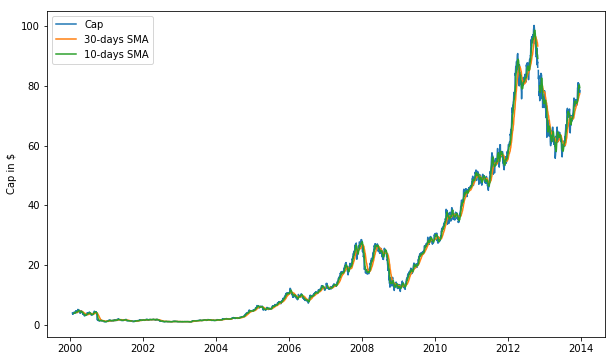

In [15]:
ticker = 'AAPL'
start_date = '2000-01-01'
end_date = '2013-12-20'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_SP.loc[start_date:end_date, :].index, df_SP.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling_SP.loc[start_date:end_date, :].index, long_rolling_SP.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling_SP.loc[start_date:end_date, :].index, short_rolling_SP.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

In [16]:
# Calculate Market means & Simple Moving Averages
Market_means_SP = df_SP.sum(axis=1).mean()
SMA_10d_SP = short_rolling_SP / Market_means_SP
SMA_30d_SP = long_rolling_SP / Market_means_SP
SMA_df_SP = df_SP / Market_means_SP

# Validated, De-meaned & Cleaned
SMA_10d_vdc_SP = (SMA_10d_SP/SMA_10d_SP.loc[SMA_10d_SP.first_valid_index()]).pct_change(periods=1).shift(-1).dropna()
SMA_30d_vdc_SP = (SMA_30d_SP/SMA_30d_SP.loc[SMA_30d_SP.first_valid_index()]).pct_change(periods=1).shift(-1).dropna()

# Reduce Market dates to dates without Nans
Cap_Market_SP = SMA_df_SP[29:-1]
Cap_Market_SP = Cap_Market_SP[Cap_Market_SP.index.isin(SMA_30d_vdc_SP.index)]
SMA_10d_vdc_SP = SMA_10d_vdc_SP[SMA_10d_vdc_SP.index.isin(Cap_Market_SP.index)]

In [20]:
# Time stamps & number of stocks
ts = Cap_Market_SP.shape[0]
ns = Cap_Market_SP.shape[1]

# number of signals
k = 2

# Dataframe to hold results
results = pd.DataFrame([],index = Cap_Market_SP.columns,columns=['kappa','sigma','sigma^2','w1','w2'])

# Calibration with TF
tf.reset_default_graph()
x = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='x')
s1 = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='s1') 
s2 = tf.placeholder(shape=(None,ns),dtype=tf.float32,name='s2')

# Variables
N_k = ns
N_s = ns
N_w = ns
kappa = tf.get_variable("kappa",initializer=tf.random_uniform([N_k],minval= 0.0,maxval=1.0))
sigma = tf.get_variable("sigma",initializer=tf.random_uniform([N_s],minval=0.0,maxval=0.1))

# Weights
w1_init = tf.random_normal([N_w],mean=0.5,stddev=0.1 )
w2_init = 1-w1_init
w1 = tf.get_variable("w1",initializer=w1_init)
w2 = tf.get_variable("w2",initializer=w2_init )
W1 = w1*tf.ones(ns)
W2 = w2*tf.ones(ns)

# Parameters
mu = tf.zeros([ns])
Sigma = sigma*tf.ones([ns])
theta1 = tf.multiply(W1,s1)
theta2 = tf.multiply(W2,s2)
scale = tf.slice(x,[0,0],[1,-1] )
theta = tf.multiply(scale,tf.cumprod(1+tf.add(theta1,theta2)))
r = tf.divide(tf.subtract(tf.manip.roll(x,shift=-1,axis = 0),x),x)
v = tf.subtract(r,tf.multiply(kappa,tf.subtract(theta,x)))
vuse = tf.slice(v,[0,0],[tf.shape(v)[0]-1,-1] )

#  Constraints 
clip_w1 = w1.assign(tf.maximum(0.,w1))
clip_w2 = w2.assign(tf.maximum(0.,w2))
clip = tf.group(clip_w1,clip_w2)
dist = tf.contrib.distributions.MultivariateNormalDiag(loc=mu, scale_diag=Sigma)
log_prob = dist.log_prob(vuse)
reg_term = tf.reduce_sum(tf.square(w1+w2-1))
neg_log_likelihood = -tf.reduce_sum(log_prob)+0.01*reg_term

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = optimizer.minimize(neg_log_likelihood)

In [21]:
# Maximum Iterations & Tolerance
max_iter = 2500
tol = 1e-10

# Save the Model
saver = tf.train.Saver()

# Run TF Session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = sess.run([neg_log_likelihood], feed_dict={x:Cap_Market_SP,s1:SMA_10d_vdc_SP,s2:SMA_30d_vdc_SP})
    i=1

    # Print Calibration
    print( "Calibration" )
    print("Iteration|      Loss      |   difference")
    while True:
        sess.run(train_op,feed_dict={x:Cap_Market_SP,s1:SMA_10d_vdc_SP,s2:SMA_30d_vdc_SP})
        sess.run(clip)
        # update loss
        new_loss = sess.run(neg_log_likelihood,feed_dict={x:Cap_Market_SP,s1:SMA_10d_vdc_SP,s2:SMA_30d_vdc_SP})
        loss_diff = np.abs(new_loss-losses[-1])
        losses.append(new_loss)
        if i%min(1000,(max_iter/20))==1:
            print ("{:8} | {:14.4f} | {:12.4f}".format(i,new_loss,loss_diff))
        if loss_diff < tol:
            print('Loss converge in {} iterations!'.format(i))
            break
        if i >= max_iter:
            print('Maximum number of iterations reached (no convergence).')
            break
        i += 1

    # Put data in pandas Dataframe.
    results['kappa'] = sess.run(kappa)
    results['sigma'] = sess.run(sigma)
    results['sigma^2'] = sess.run(sigma)**2
    results['w1'] = sess.run(W1)
    results['w2'] = sess.run(W2)
    fitted_means = sess.run(theta, feed_dict={x:Cap_Market_SP,s1:SMA_10d_vdc_SP,s2:SMA_30d_vdc_SP})
    mean_levels = pd.DataFrame(fitted_means,index=Cap_Market_SP.index,columns=Cap_Market_SP.columns)
    
    # Print Results
    print( "Results" )
    print(results.round(4))
    
    save_path = saver.save(sess, './part1.ckpt')
    print( 'Checkpoint saved in: {}'.format(save_path))

Calibration
Iteration|      Loss      |   difference
       1 |   7252435.0000 | 2390901.0000
     126 |  -2114036.7500 |    5316.7500
     251 |  -2548872.0000 |    2405.5000
     376 |  -2786659.0000 |    1486.5000
     501 |  -2932495.2500 |     876.7500
     626 |  -3010911.2500 |     387.5000
     751 |  -3043506.5000 |     207.0000
     876 |  -3065816.2500 |     155.2500
    1001 |  -3082925.5000 |     121.2500
    1126 |  -3096468.7500 |      96.0000
    1251 |  -3107461.7500 |      80.0000
    1376 |  -3116561.0000 |      66.7500
    1501 |  -3124219.2500 |      56.0000
    1626 |  -3130753.5000 |      49.0000
    1751 |  -3136391.7500 |      42.0000
    1876 |  -3141308.0000 |      36.7500
    2001 |  -3145629.5000 |      32.7500
    2126 |  -3149456.5000 |      28.7500
    2251 |  -3152869.0000 |      25.7500
    2376 |  -3155928.0000 |      22.7500
Maximum number of iterations reached (no convergence).


ValueError: Shape of passed values is (419, 3289), indices imply (30, 2050)

Part 3 Conclusion, the model for the S&P500 did work in the same way as the one for the Dow Jones in Part 1. But the calibration of the model did not converged in less than a 2,500 iterations, this limit was set relatively low and still took almost 3 hours to run, this is for 419 stocks instead of 30 as in part 1. The error at saving means level was corrected.

## Part 4 (Optional): Show me something else.

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [ ]:
# Put the rest of your code and analysis for Part 4 here.